# RNN (LSTM) based model for predictive maintenance

In [1]:
! pip install pandas matplotlib seaborn keras
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
# plt.style.use(['dark_background'])
from sklearn import preprocessing

from datetime import datetime, timedelta
from typing import Set, List, Tuple

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
data_df = pd.read_csv('device_failure.csv', encoding='ISO-8859-1', delimiter=',')

In [3]:
data_df[:4]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0


In [4]:
features = sorted(list(set(data_df.columns.tolist()) - { 'date', 'device', 'failure'}))
# sns.distplot(data[(data['attribute2'] > 0) & (data['attribute2'] < 2000)]['attribute2'])
features

['attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute7',
 'attribute8',
 'attribute9']

In [5]:
for feature in features:
    unique_values = sorted(data_df[feature].unique())
    info_str = '{} values:{}'.format(len(unique_values), unique_values) if (len(unique_values) < 120) else '{}'.format(len(unique_values))
    print('{}: unique items {}'.format(feature, info_str))

attribute1: unique items 123877
attribute2: unique items 558
attribute3: unique items 47 values:[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 21, 24, 25, 34, 35, 36, 38, 53, 56, 61, 62, 70, 72, 100, 107, 208, 220, 263, 266, 279, 318, 323, 377, 382, 406, 1162, 1326, 1331, 2112, 2693, 24929]
attribute4: unique items 115 values:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 62, 65, 67, 69, 73, 74, 76, 79, 80, 86, 90, 91, 94, 95, 97, 100, 108, 112, 118, 121, 122, 128, 129, 135, 147, 160, 164, 173, 175, 186, 204, 214, 215, 235, 236, 256, 288, 297, 299, 300, 305, 322, 331, 399, 400, 401, 405, 406, 431, 486, 487, 521, 529, 533, 763, 841, 1033, 1074, 1666]
attribute5: unique items 60 values:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38

In [6]:
# sorted(data_df['attribute7'].unique()/8)

attribute7 and attribute8 both have the same support 28 values which seems to be more of categorical-like information

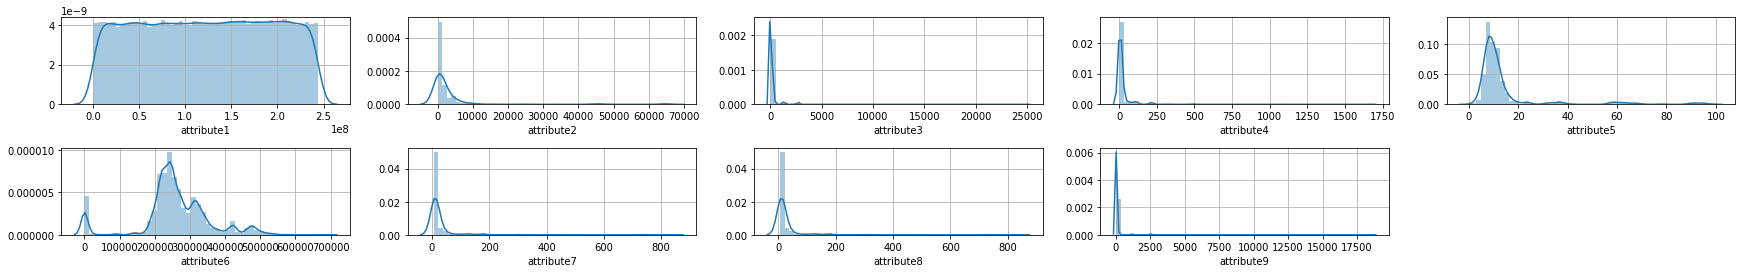

In [7]:
# Features disributions (pre-visulation: getting the support of dimension)
from matplotlib import gridspec
plt.figure(figsize=(30, 4)) 
gs = gridspec.GridSpec(2, 1 + len(features)//2, hspace=.5) 
for idx, feature in enumerate(features):
    plt.subplot(gs[idx])
    sns.distplot(data_df[data_df[feature] >0][feature])
    plt.grid()


In [8]:
data_to_normalize = data_df[features].values
min_max_scaler = preprocessing.MinMaxScaler()
data_normalized = min_max_scaler.fit_transform(data_to_normalize)

/Users/wo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
data_normalized

array([[8.83223757e-01, 8.61962812e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.74311534e-04],
       [2.51374455e-01, 0.00000000e+00, 1.20341771e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.09820707e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.79433218e-02, 7.43750770e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.29601711e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.19783954e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

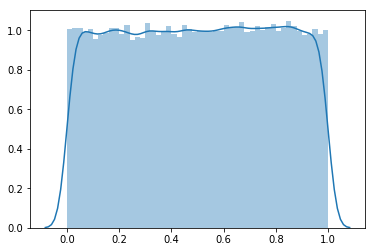

In [10]:
sns.distplot(data_normalized[:,0])

In [11]:
type(data_df[data_df['device'] == 'S1F0166B'] ['date'])

pandas.core.series.Series

## Checking telemetry transmision frequency for each of the devices

checking that telemetry transmision frequency equal 1 day and cleaning/recovering the data respectively

In [12]:
# some helpers for check aggregation

def to_date(str_date, format='%Y-%m-%d') -> datetime:
    """ A helper function to extract datetime from an str. date """
    return datetime.strptime(str_date, format)

def data_freq_check(time_stamps: pd.core.series.Series) -> Set[datetime]:
    """ A helper function to return a set of distinct time interval,
        between successive timestamps"""
    ts_array = np.array(list(map(to_date,time_stamps.tolist())))
    return set(ts_array[1:] - ts_array[:-1])


# a small test
tmp = list(map(to_date, data_df[data_df['device'] == 'S1F0166B']['date'].tolist()))
assert data_freq_check(data_df[data_df['device'] == 'S1F0166B']['date']) == set(np.array(tmp[1:]) - np.array(tmp[:-1]))

# data_normalized.groupby('device').aggregate 


In [13]:
def ts_check_aggregation(grp) -> pd.Series:
    """ aggregation to check the timestamp interval for all the device """
    unique_ts_intervals = data_freq_check(grp['date']) 
    names = {
        'ts_intervals': unique_ts_intervals,
        'ts_intervals_count': len(unique_ts_intervals),
        'failed': any(grp['failure']),
        'timeseries_length': grp['date'].count()
    }
    return pd.Series(names, index=['ts_intervals', 'ts_intervals_count', 'failed', 'timeseries_length'])

ts_check = data_df.groupby('device').apply(ts_check_aggregation) # aggregate({'date': {'ts_freq_check': lambda ts_:data_freq_check(ts_)}})
ts_check[ts_check['ts_intervals'] != {timedelta(days=1)}].head(20)

,ts_intervals,ts_intervals_count,failed,timeseries_length
device,,,,
S1F01R2B,"{1 day, 0:00:00, 14 days, 0:00:00}",2,False,223
S1F02A0J,"{1 day, 0:00:00, 14 days, 0:00:00}",2,False,227
S1F04DH8,"{1 day, 0:00:00, 58 days, 0:00:00}",2,False,25
S1F06ZX2,"{1 day, 0:00:00, 20 days, 0:00:00}",2,False,112
S1F0AADQ,"{1 day, 0:00:00, 3 days, 0:00:00}",2,False,271
S1F0AEFT,"{1 day, 0:00:00, 3 days, 0:00:00}",2,False,271
S1F0BWZ3,"{1 day, 0:00:00, 14 days, 0:00:00}",2,False,279
S1F0CVWK,"{1 day, 0:00:00, 3 days, 0:00:00}",2,False,283
S1F0E9EP,"{1 day, 0:00:00, 2 days, 0:00:00}",2,False,304


In [14]:
info = 'with other than one day sampling/timestamp interval'
print( '{} failed devices {} out of  {} failed devices'.\
      format(ts_check[(ts_check['ts_intervals'] != {timedelta(days=1)}) & (ts_check['failed'] == True) ]['ts_intervals'].count(),
             info,
             ts_check[(ts_check['failed'] == True) ]['ts_intervals'].count()))

print( '{} Normal (NYF :not yet failed) device (s) {} out of  {}  NYF devices'.\
      format(ts_check[(ts_check['ts_intervals'] != {timedelta(days=1)}) & (ts_check['failed'] == False) ]['ts_intervals'].count(),
             info,
             ts_check[(ts_check['failed'] == False) ]['ts_intervals'].count()))

15 failed devices with other than one day sampling/timestamp interval out of  106 failed devices
159 Normal (NYF :not yet failed) device (s) with other than one day sampling/timestamp interval out of  1063  NYF devices


In [15]:
15./106

0.14150943396226415

We will try to recover  these 15 instances of the failed devices timeseries as the data size is small 
and these 15 instances might help getting better performance, but first we study the timeseries length that we can consider 
to build the model

In [16]:
# Check timeseries length fo the devices (percentile)
# to choose an adequate timeseries length to train with: enough long but not too much long to keep enough training candidates
from collections import Counter
from operator import itemgetter
def percentile_timeseries_length_data_coverage(timeseries_lengths: List[int], min_percentage=50) -> List[tuple]:
    """
    A helper function to extract percentile of data coverage given a timeseries length threshold 
    (only extract the data for plotting)
    """
    timeseries_length_counter = Counter()
    timeseries_length_counter.update(timeseries_lengths)
    cumulative_count = 0
    timeseries_length_data_count = []
    for ts_length, count_ in sorted(timeseries_length_counter.items(), key=itemgetter(0), reverse=True):
        cumulative_count += count_
        timeseries_length_data_count.append((ts_length, cumulative_count))
    return [ (ts_length, 100*float(data_count_)/cumulative_count) for ts_length, data_count_ in timeseries_length_data_count if 100*float(data_count_)/cumulative_count > min_percentage ]



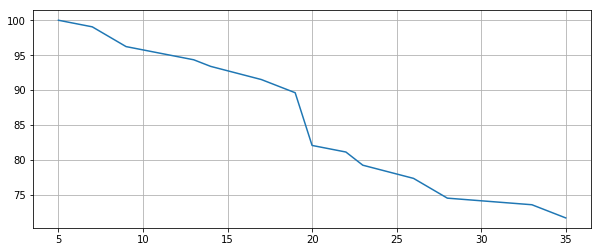

In [17]:
ts_length, data_coverage = zip(*percentile_timeseries_length_data_coverage(ts_check[(ts_check['failed'] == True)]['timeseries_length'].tolist(), 70))
plt.figure(figsize=(10, 4)) 
plt.plot(ts_length, data_coverage)

plt.grid()

it seems that 17 days before failure seems is a plausible choice 10 + 7 where 10 days is the sequence/size of a training time series that we slide (roll) 1 day each time and that generates from  each while each time the rest is used to build the labels. Labels generation process/setup will be detailed later.

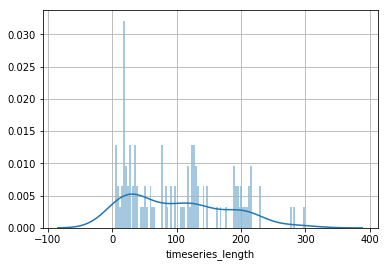

In [18]:
sns.distplot(ts_check[(ts_check['failed'] == True) & (ts_check['timeseries_length'] >=1)]['timeseries_length'],100)
plt.grid()

In [19]:
# Recovering analysis for the missing telemetry: the timeseries with rate/freq (!=1 day)
def data_freq_check_detailed(time_stamps: pd.core.series.Series) -> int:
    """ A helper function to return telemetry intervals (between 2 successive transmissions)"""
    ts_array = np.array(list(map(to_date,time_stamps.tolist())))
    return ts_array[1:] - ts_array[:-1]

In [20]:
def ts_check_aggregation_detailed(grp) -> pd.Series:
    """ Aggregation to check the timestamp interval for all the device """
    intervals_list = data_freq_check_detailed(grp['date'])
    interval_not_one_day = [ index for index, x in enumerate(intervals_list) if x != timedelta(days=1)]
    min_index = max(interval_not_one_day) if interval_not_one_day else 0
    names = {
        'interval_not_one_day': interval_not_one_day,
        'min_index': min_index,
        'ts_intervals_set': set(intervals_list),
        'failed': any(grp['failure']),
        'timeseries_length': grp['date'].count(),
        'recoverable_timeseries_length': grp['date'].count() -  min_index
    }
    return pd.Series(names, index=['interval_not_one_day', 'min_index', 'ts_intervals_set', 'failed', 'timeseries_length',
                                   'recoverable_timeseries_length'])

In [21]:
ts_check_detailed = data_df.groupby('device').apply(ts_check_aggregation_detailed)
ts_check_detailed[(ts_check_detailed['ts_intervals_set'] != {timedelta(days=1)}) & (ts_check_detailed['failed'] == True)]  #.count() # head(20)

,interval_not_one_day,min_index,ts_intervals_set,failed,timeseries_length,recoverable_timeseries_length
device,,,,,,
S1F0PJJW,[47],47,"{1 day, 0:00:00, 81 days, 0:00:00}",True,60,13
S1F0RR35,[83],83,"{1 day, 0:00:00, 42 days, 0:00:00}",True,87,4
S1F0S57T,[12],12,"{1 day, 0:00:00, 71 days, 0:00:00}",True,26,14
S1F10E6M,[5],5,"{1 day, 0:00:00, 23 days, 0:00:00}",True,7,2
S1F11MB0,[5],5,"{1 day, 0:00:00, 23 days, 0:00:00}",True,7,2
W1F03D4L,[5],5,"{1 day, 0:00:00, 14 days, 0:00:00}",True,125,120
W1F03DP4,[5],5,"{1 day, 0:00:00, 14 days, 0:00:00}",True,14,9
W1F0FKWW,[5],5,"{1 day, 0:00:00, 43 days, 0:00:00}",True,97,92
W1F0X5GW,[12],12,"{1 day, 0:00:00, 119 days, 0:00:00}",True,22,10


It seems that we can recover some to be useful for training since the telemetry freq. problems appears early (enough) before the failure in the timeseries 

## Failure (failed devices) exploration 

In [22]:
# unique devices in the data set 
data_df.groupby('device').aggregate({'device': 'nunique'}).count()

device    1169
dtype: int64

In [23]:
# Failure insight (how many of the divices actually has failed at least once)
device_failure = data_df.groupby('device').aggregate({'failure': { 'has_failed': lambda f_: any(f_),'failure_count': lambda f_: np.sum(f_)}})
device_failure.columns = device_failure.columns.get_level_values(1)
device_failure.reset_index()
device_failure[device_failure['failure_count'] > 1 ] 
# seems that the failure might be a fatility for a device since (at least from the data point of vue) to be confirmed/or not with the date information
# Because it might be the device get repared and never fail again  (we only have one-shot per device)

/Users/wo/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,has_failed,failure_count
device,,


In [24]:
# lets monitor some devices 
device_failure[device_failure['failure_count'] > 0].count()

has_failed       106
failure_count    106
dtype: int64

In [25]:
def failed_devices(sample_size=None):
    if sample_size is None:
        return device_failure[device_failure['failure_count'] > 0].reset_index()['device'].tolist()
    return device_failure[device_failure['failure_count'] > 0][:sample_size].reset_index()['device'].tolist()
    

In [26]:
fd_sample = failed_devices(sample_size=8)
# fd_sample

In [27]:
def extract(df, device, attributes: List) -> dict:
    """ extract device attribute: projection on device / attributes"""
    return {'attributes': attributes,  'data': df[df['device'] == device][attributes].values.transpose()}

In [28]:
# Examine data before failure fo the attribute: attribute1
device_att_sample  = { device:extract (data_df, device, features) for device in fd_sample}


In [29]:
def plot_ts(data_dict, dim=0, last_n=50):
    """ a helper function to visualize selected attributes (ts tail) for selected devices"""
    plt.figure(figsize=(30, 4))
    plt.title('Attribute (un-normalized) behaviour before failure')
    for device, data_ in data_dict.items():
        plt.plot(np.pad(data_['data'][dim][-last_n:],(60-len(data_['data'][dim][-last_n:]), 0), 'constant'),  label='{} for device{}'.format(data_['attributes'][dim], device))
    plt.legend()
    plt.grid()

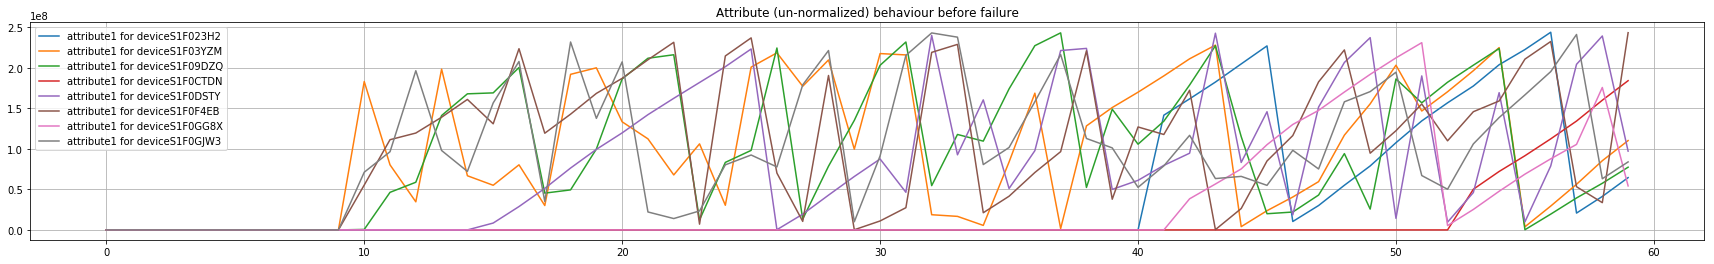

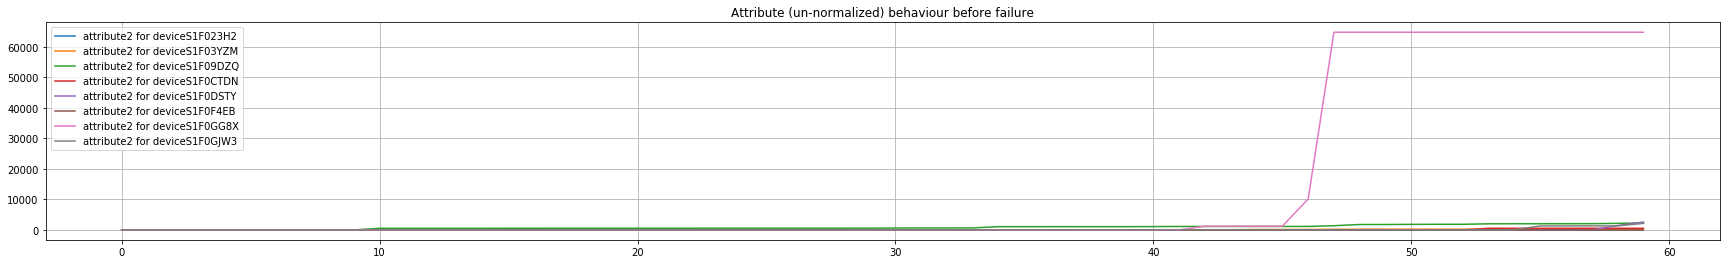

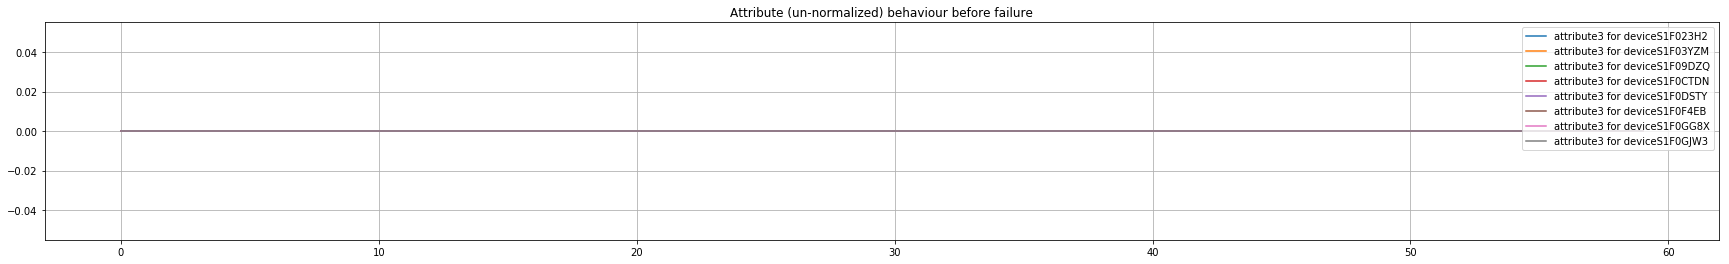

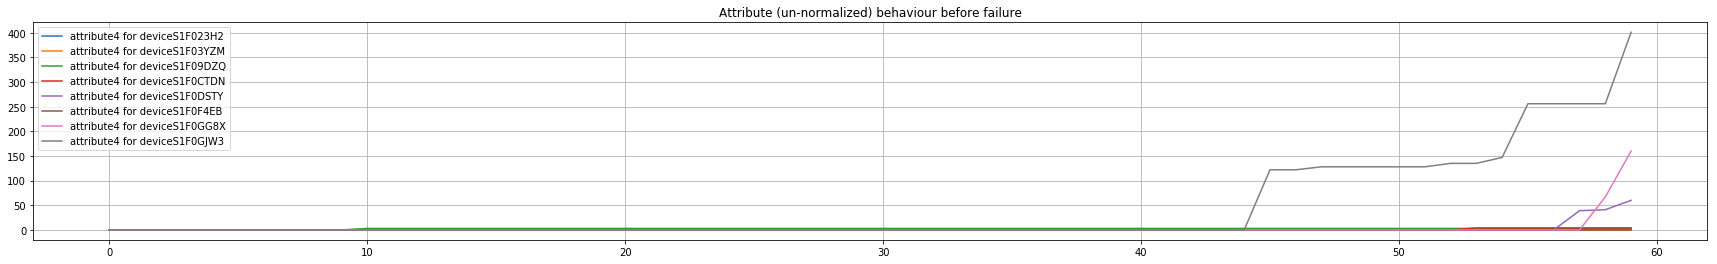

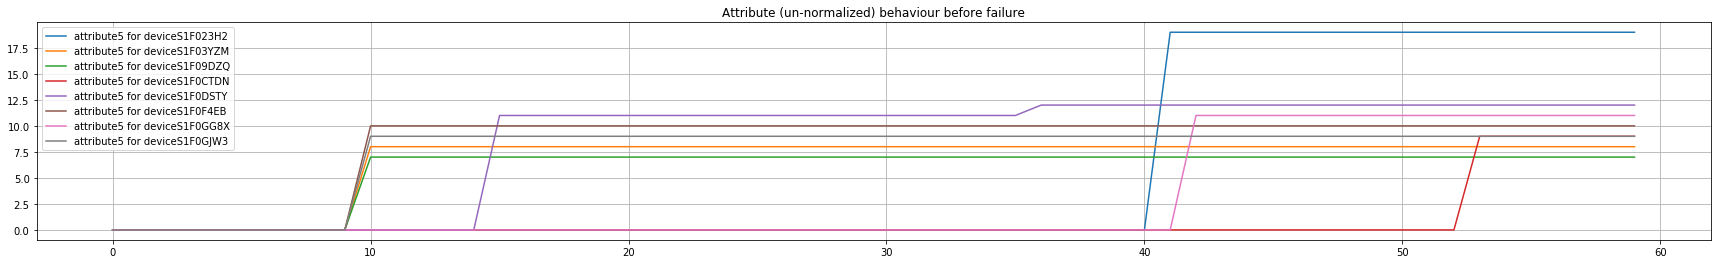

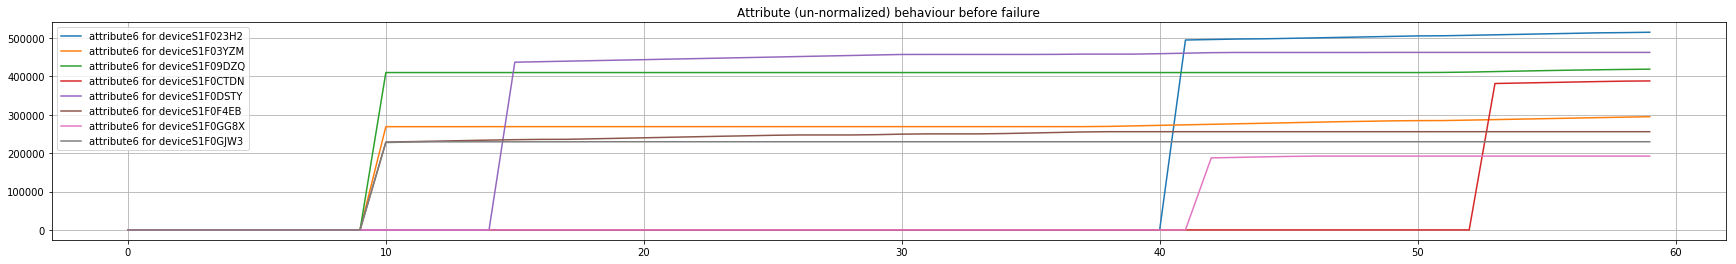

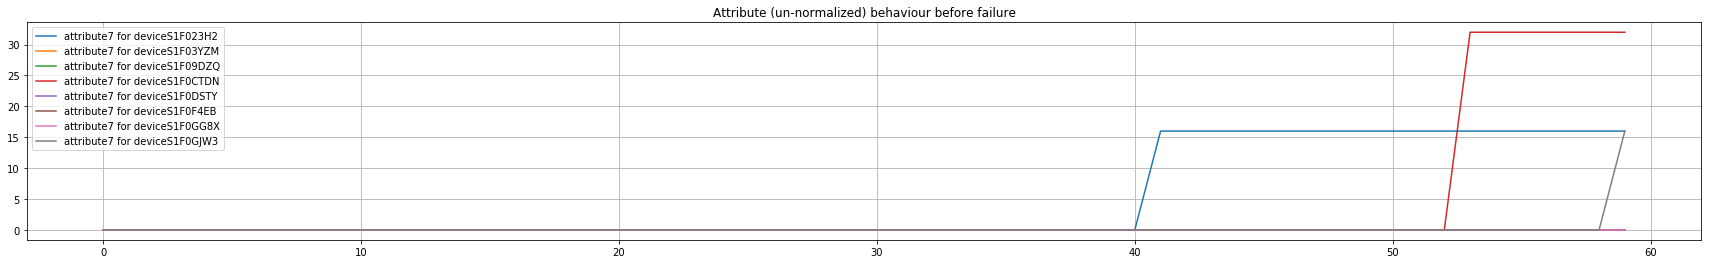

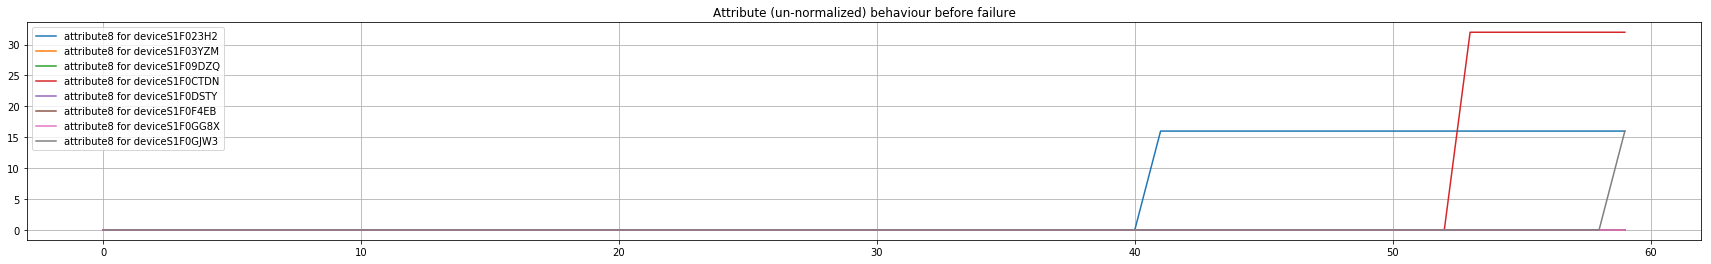

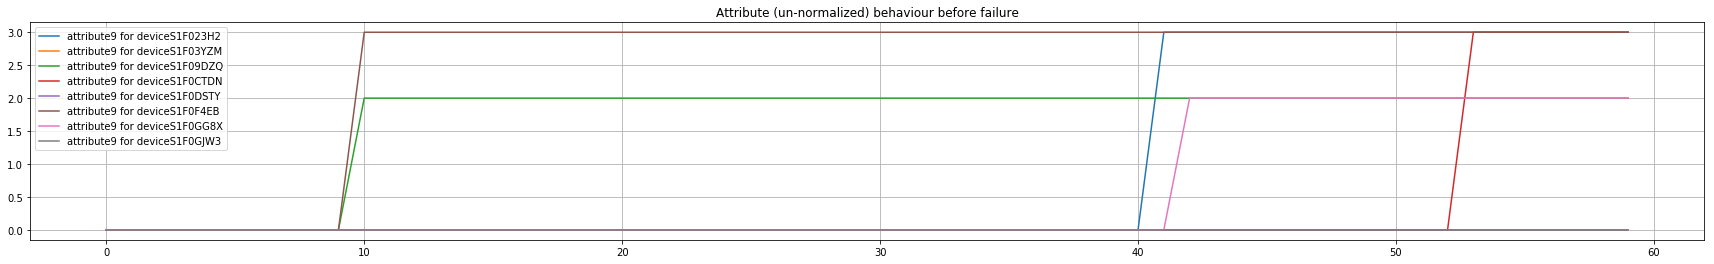

In [30]:
# Getting some insight about attributes behaviour before failure
for dim , feature in enumerate(features):
    plot_ts(device_att_sample, dim=dim)

## Normalize the data and extract timeseries for each of the devices

In [31]:
normalized_df = data_df
for dim, feature in enumerate(features):
    normalized_df[feature] = data_normalized[:,dim]
normalized_df['features'] = normalized_df[features].values.tolist() 
normalized_df.drop(columns=features).head()


,date,device,failure,features
0,2015-01-01,S1F01085,0,"[0.8832237570762538, 0.0008619628124615195, 0...."
1,2015-01-01,S1F0166B,0,"[0.251374454576316, 0.0, 0.0001203417706285851..."
2,2015-01-01,S1F01E6Y,0,"[0.709820706504714, 0.0, 0.0, 0.0, 0.113402061..."
3,2015-01-01,S1F01JE0,0,"[0.32642691617547404, 0.0, 0.0, 0.0, 0.0515463..."
4,2015-01-01,S1F01R2B,0,"[0.5569354168550827, 0.0, 0.0, 0.0, 0.14432989..."


In [32]:
def build_features_label(grp) -> pd.Series:
    """ Aggregation to build features and label: 
    it transforms the original data by agregating sequence x seqence dim matrix for each of the devices as features, as well as extracting the label and useful length
    a useful timeseries length defined by an uniform 1 day telemetery interval look back starting from the failure date."""
    intervals_list = data_freq_check_detailed(grp['date'])
    interval_not_one_day = [ index for index, x in enumerate(intervals_list) if x != timedelta(days=1)]
    min_index = max(interval_not_one_day) if interval_not_one_day else 0
    timeseries_length = grp['date'].count() # original timeseries length
    
    features_values = np.array(grp['features'].tolist()[min_index:])
    names = {
        'features': features_values,
        'failed': any(grp['failure']),
        'useful_length': timeseries_length -  min_index
    }
    return pd.Series(names, index=['features', 'failed', 'useful_length'])

## Problem setup/description

In [33]:
# Some global parameters defining the timeseries length as well as the model training features/label setup
timestamp_before_before_failure = 5 # used to get some negative (or normal) example from timeseries with failure
timeseries_length = 10 # the input dimension of a training feature data (which means a ten day lookback data to predict the future)
label_timeseries_length=7 # label timeseries length for example  0 0 0 0 1 1 1 (means that the device will fail in the 5 day) considering  features including up to the  day-7
future_failure_dim=0 # artificially extending the time series in the future, for example (future_failure_dim=2) will append 1 1 to  0 0 0 0 1 1 1  so we extend label to 9 days (just experimenting)


The previous configuration (or global parameters) means) the setup is as follow we consider up to 7 days before failure, the label is a sequence of binary elements : 0 0 0 0 0 0 1 means that the device will fail in the 7th day while the data is taken from the days before up to for this configuration 27 in the past, in other words from  f-27 to f-7 (a seq of 20 days of multi dimensional data/features)

The parameter timestamp_before_before_failure makes it possible to explore the failure example to extract out some normal behaviour (at least from the labeling context of 7 days) and the timeseries_length sequence between f-(27+5) f(7+5) to f-28 to f-8 will have negative label signature of 0 0 0 0 0 0 0 telling that this device is not going to fail during the next 7 days

Getting closer to the failure days for example f-3 the label of the previous 20 (timeseries_length) features sequence will be 0 0 1 1 1 1 1 1 which tells that the device is going to fail the third day but logically enforces that if not then the next day or the day after ... for sure the proposed algoirthm tries to predict this sigmoid like function of days accurately

This label modeling will enforce a logical order and prior in the failure prediction: the probability/score goes higher in the future. The prediction visulization of the model for a test sample shows that later in the notebook.  

In [34]:
features_normalized_df = normalized_df.groupby('device').apply(build_features_label)
features_normalized_df = features_normalized_df[features_normalized_df['useful_length'] >= timeseries_length+label_timeseries_length].reset_index()

In [35]:
features_normalized_df.head()

,device,features,failed,useful_length
0,S1F01E6Y,"[[0.709820706504714, 0.0, 0.0, 0.0, 0.11340206...",False,48
1,S1F01R2B,"[[0.781078860826357, 0.0, 0.0, 0.0, 0.14432989...",False,218
2,S1F01XDJ,"[[0.9327483586499051, 0.0, 0.0, 0.0, 0.0721649...",False,106
3,S1F023H2,"[[0.5795990898354914, 0.0, 0.0, 0.000600240096...",True,19
4,S1F02A0J,"[[0.29882274336480374, 0.0, 4.011392354286173e...",False,222


In [36]:
# ft = features_normalized_df[features_normalized_df['device'] == 'S1F01E6Y']['features'][0]

## Building the train/validation and problem setup

In [37]:
def process_df(df: pd.DataFrame, timeseries_length:int=timeseries_length, label_timeseries_length=label_timeseries_length, future_failure_dim=future_failure_dim, failed_device_normal_regime_look_back=10):
    """ processing the dataframe rows into features -> label """
    for index, row in df.iterrows():
        if row['failed']:
            max_look_back_before_failure = min(row['useful_length'], timeseries_length+label_timeseries_length+failed_device_normal_regime_look_back)
            for timeseries_start in range(-max_look_back_before_failure, -timeseries_length-label_timeseries_length-1):
                # Create some negative example to improve extrapolation perf. (time neighborhood of ) and lower false positive alerts
                # this section is added after assesed problem of low prediction perf. (false positive) on failed device normal operating regime (enough early before failure)
                # while the model performs well on the time neighborhood of failure (when ground truth time to failure is within range(label_timeseries_length))
                labels = np.zeros(label_timeseries_length)
                fail_in_n_days = -timeseries_start
                yield row['device'], timeseries_start, int(row['failed']) ,row['features'][timeseries_start:timeseries_start+timeseries_length, :], labels, fail_in_n_days
        for ts_index in range(label_timeseries_length):
            labels = np.zeros(label_timeseries_length)
    
            if row['failed']:
                labels[label_timeseries_length - 1 - ts_index:] = 1
                labels = np.concatenate((labels, np.ones(future_failure_dim)))
                fail_in_n_days = label_timeseries_length-ts_index-1 # to be used for classification (after one-hot-encoding transformation) or in regression problem
            
            else:
                fail_in_n_days = -1
                labels = np.concatenate((labels, np.zeros(future_failure_dim)))
            timeseries_start = -timeseries_length-label_timeseries_length + ts_index
            
            yield row['device'], ts_index, int(row['failed']) ,row['features'][timeseries_start:timeseries_start+timeseries_length, :], labels, fail_in_n_days    

In [38]:
features_normalized_df.head()

,device,features,failed,useful_length
0,S1F01E6Y,"[[0.709820706504714, 0.0, 0.0, 0.0, 0.11340206...",False,48
1,S1F01R2B,"[[0.781078860826357, 0.0, 0.0, 0.0, 0.14432989...",False,218
2,S1F01XDJ,"[[0.9327483586499051, 0.0, 0.0, 0.0, 0.0721649...",False,106
3,S1F023H2,"[[0.5795990898354914, 0.0, 0.0, 0.000600240096...",True,19
4,S1F02A0J,"[[0.29882274336480374, 0.0, 4.011392354286173e...",False,222


In [39]:
def build_X_y(df:pd.DataFrame, features_index, label_index, shuffle=True) -> Tuple[List]:
    """ a helper function to build features/target for training and validation from a filtered dataframe (same structure as the features_normalized_df)
        :return 
    """
    X,y = ([],[])
    for item in process_df(df):
        X.append(item[features_index])
        y.append(item[label_index])
    X_y = np.array(list(zip(X,y)))
    if shuffle:
        np.random.shuffle(X_y)
    return X_y

In [40]:
# Data needed to be splitted and balanced

In [41]:
failed_device_data = build_X_y(features_normalized_df[features_normalized_df['failed'] == True], features_index=3, label_index=4)
normal_device_data = build_X_y(features_normalized_df[features_normalized_df['failed'] == False], features_index=3, label_index=4)

In [42]:
print('failed device data shape:', failed_device_data.shape)
print('normal device data shape:', normal_device_data.shape)

failed device data shape: (1353, 2)
normal device data shape: (4256, 2)


In [43]:
def balance_split_train_valid(failed_class_data, not_yet_failed, train_rate=.8):
    """ As the data is not balanced between failed devices and normal ones (more correctly not failed yet)  
        This tool simply repeats the failed class item so within an epoch we visit as much failed data example as normal ones.
        train_rate is the split rate set by default to .8 -> 80% training / 20% validation
        """
    split_f = int(failed_class_data.shape[0]*train_rate)
    split_n = int(not_yet_failed.shape[0]*train_rate)
    
    train_f, valid_f = failed_class_data[:split_f, :],  failed_class_data[split_f:, :]
    train_n, valid_n = not_yet_failed[:split_n, :][:2*train_f.shape[0], :],  not_yet_failed[split_n:, :]
    
    # TODO balance the f/n data 
    print(train_f.shape, train_n.shape)
    train_data = np.concatenate((train_f, train_n), axis=0)
    # train data
    train_data_X = np.array([ x for x in train_data[:,0]])
    train_data_y = np.array([ x for x in train_data[:,1]])
    # validation data
    valid_data_X, valid_data_y  = np.array([ x for x in train_data[:,0]]), np.array([ x for x in train_data[:,1]])
    
    return train_data_X, train_data_y, valid_data_X, valid_data_y
    

In [44]:
train_X, train_y, valid_X, valid_y = balance_split_train_valid(failed_device_data, normal_device_data)

(1082, 2) (2164, 2)


In [45]:
from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.layers import Layer, Input, Dense, LSTM, ReLU, LeakyReLU, Activation, TimeDistributed, BatchNormalization, Dropout

def fcn_ft_eng(input_dim, layers=[], layer_dims=[]) -> List[Layer]:
    """ a feature extractor based on FCN (defined through layer_dims)"""
    layers.append(TimeDistributed(Dense(layer_dims[0], input_dim=input_dim)))
    layers.append(LeakyReLU(alpha=.1))
    for layer_dim in layer_dims[1:]:
        # layers.append(TimeDistributed(Dense(layer_dim, activation=activation_function)))
        layers.append(Dense(layer_dim))
        layers.append(LeakyReLU(alpha=.1))
    return layers

def add_rnn(layers=[], activation_function="tanh", rnn_dims=[10]) -> List[Layer]:
    """ building a multi-layer RNN  for the Neural network model"""
    for dim in rnn_dims[:-1]:
        layers.append(LSTM(dim, return_sequences=True, activation=activation_function)) 
    layers.append(LSTM(rnn_dims[-1], return_sequences=False, activation=activation_function))
    layers.append(Dropout(rate=.3))
   
    layers.append(Dense(label_timeseries_length+future_failure_dim, activation="sigmoid"))
    return layers
          


/Users/wo/miniconda3/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [46]:
# Building the model
data_dim = len(features)
input_layer = Input(shape=(timeseries_length, data_dim))
# Stacking layers
output = input_layer
for layer in add_rnn(layers=fcn_ft_eng(data_dim, layer_dims=[data_dim, data_dim//2]), activation_function="relu", rnn_dims=[32, 32]):
    output = layer(output)
model = Model(input_layer, output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 9)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 9)             90        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 9)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10, 4)             40        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10, 4)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
__________

In [47]:
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#TODO: use a custom loss to penalize more false negative failure detection.               
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [48]:
history = [] # a history for multiple round (to support interactive training: multi round of several epochs)

In [91]:
for round in range(4):
    history.append(model.fit(train_X, train_y, validation_data=(valid_X, valid_y), epochs=100, batch_size=512, verbose=1, shuffle=True))

Train on 3246 samples, validate on 3246 samples
Epoch 1/100
3246/3246 [==============================] - 0s 109us/step - loss: 0.1489 - val_loss: 0.1419
Epoch 2/100
3246/3246 [==============================] - 0s 73us/step - loss: 0.1538 - val_loss: 0.1611
Epoch 3/100
3246/3246 [==============================] - 0s 79us/step - loss: 0.1587 - val_loss: 0.1425
Epoch 4/100
3246/3246 [==============================] - 0s 82us/step - loss: 0.1524 - val_loss: 0.1429
Epoch 5/100
3246/3246 [==============================] - 0s 77us/step - loss: 0.1485 - val_loss: 0.1400
Epoch 6/100
3246/3246 [==============================] - 0s 68us/step - loss: 0.1486 - val_loss: 0.1389
Epoch 7/100
3246/3246 [==============================] - 0s 68us/step - loss: 0.1473 - val_loss: 0.1381
Epoch 8/100
3246/3246 [==============================] - 0s 68us/step - loss: 0.1472 - val_loss: 0.1383
Epoch 9/100
3246/3246 [==============================] - 0s 69us/step - loss: 0.1471 - val_loss: 0.1381
Epoch 10/100
32

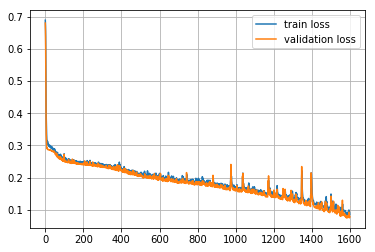

In [92]:
from functools import reduce
loss = reduce(lambda x, y: x+y, [x.history['loss'] for x in history])
val_loss = reduce(lambda x, y: x+y, [x.history['val_loss'] for x in history])


plt.plot(loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.grid()
plt.legend()

In [94]:
# Serialize model
model_name = 'interesting_3'
model_json = model.to_json()
with open("{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [84]:
features_normalized_df.head()

,device,features,failed,useful_length
0,S1F01E6Y,"[[0.709820706504714, 0.0, 0.0, 0.0, 0.11340206...",False,48
1,S1F01R2B,"[[0.781078860826357, 0.0, 0.0, 0.0, 0.14432989...",False,218
2,S1F01XDJ,"[[0.9327483586499051, 0.0, 0.0, 0.0, 0.0721649...",False,106
3,S1F023H2,"[[0.5795990898354914, 0.0, 0.0, 0.000600240096...",True,19
4,S1F02A0J,"[[0.29882274336480374, 0.0, 4.011392354286173e...",False,222


In [85]:
def get_test_devices(sample_size=10, minimum_useful_length=50) -> Tuple[list,np.ndarray]:
    """ a helper function to extract from the test set some devices that failed """
    tmp_df = features_normalized_df[(features_normalized_df['failed'] == True) & (features_normalized_df['useful_length'] >minimum_useful_length)].reset_index(drop=True)
    sample_df = tmp_df.sample(frac=max(.2,float(sample_size)/tmp_df.size))[:sample_size].reset_index(drop=True)
    return sample_df['device'].values, sample_df['features'].values

In [86]:
test_device_sample_size = 10
minimum_useful_length = timeseries_length +label_timeseries_length + 10
test_devices, test_features = get_test_devices(sample_size=test_device_sample_size, minimum_useful_length=minimum_useful_length)

In [87]:
#test_features = features_normalized_df[(features_normalized_df['failed'] == True) & (features_normalized_df['useful_length'] >50)].reset_index()['features'].values[0:10]

In [88]:
test_features[0].shape

(50, 9)

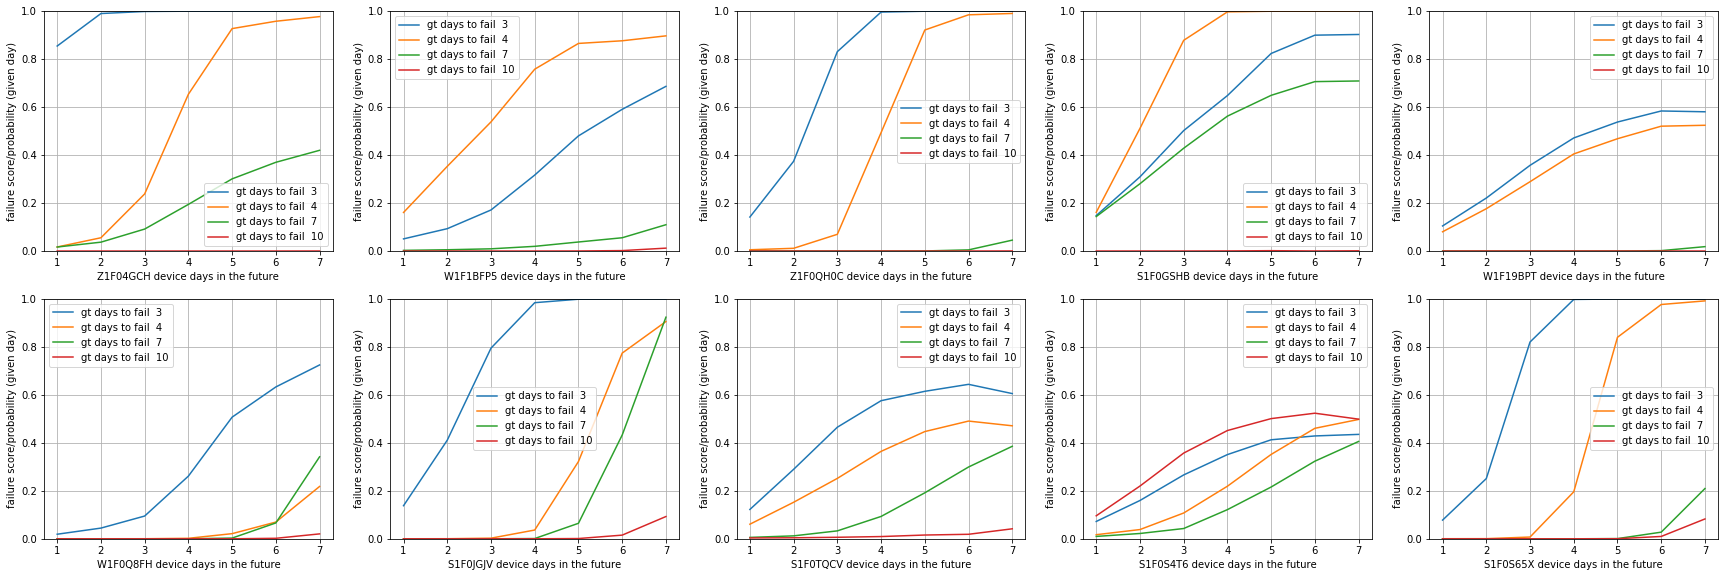

In [93]:
# Visualize failure prediction on test sample gt refers to -> ground truth

days_to_fail_config = [3, 4, 7, 10]
cols_device_per_row = 5
rows = (test_features.shape[0] // cols_device_per_row) + 1

plt_item_index = 1

plt.figure(figsize=( 6*cols_device_per_row, 5*rows))

for index in range(test_features.shape[0]):
    ax = plt.subplot(rows, cols_device_per_row, plt_item_index)
    ax.set_ylim(0, 1)
    ax.set_ylabel('failure score/probability (given day)')
    ax.set_xlabel('{} device days in the future'.format(test_devices[index]))

      
    for dtf_index, days_to_fail in enumerate(days_to_fail_config):
        pred_sample = model.predict(test_features[index][-days_to_fail - timeseries_length:-days_to_fail, :].reshape(1, timeseries_length,-1)  )
        ax.plot(range(1, 1 + label_timeseries_length+future_failure_dim),pred_sample[0], label='gt days to fail  {}'.format(days_to_fail))

    ax.grid(True)
    ax.legend()     
    plt_item_index += 1
    

In [95]:
# TODO/TRY 
# Average the scoring using the overlapping over labels
# try larger (varying) labelling period
# try sequence to sequence model
